In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = (6,6)

In [3]:
import numpy as np
import pandas as pd
import json
import tqdm
import pathlib
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

### Версии:

- `numpy`: 1.16.5
- `pandas`: 0.24.2
- `sklearn`: 0.21.3
- `tensorflow`: 2.0.0

# Загрузка данных

In [79]:
train_data = pd.read_csv(DATA_DIR.joinpath("activity_train.csv.zip"),
                         parse_dates=["date"], index_col="date",
                         compression="zip")
test_data = pd.read_csv(DATA_DIR.joinpath("activity_test.csv.zip"),
                        parse_dates=["date"], index_col="date",
                        compression="zip")
activity_test_target = pd.read_csv(DATA_DIR.joinpath("activity_test_timestamps.csv"),
                                   index_col="date",
                                   parse_dates=["date"])
atactic_test_target = pd.read_csv(DATA_DIR.joinpath("atactic_test_timestamps.csv"),
                                  index_col="date",
                                  parse_dates=["date"])

In [80]:
train_data.head(3)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f50,f51,f52,f53,f54,f55,activity,atactic_1,atactic_2,atactic_3
date,,,,,,,,,,,,,,,,,,,,,
2018-02-13 08:30:00,49.048771,294.933268,1.675466,0.000051,0.024688,0.001628,1.724180e+06,728860.217994,1.179884,0.513442,...,342.95605,332.80826,332.81665,5493.318081,4829.339027,521.341026,33.998170,NaN,NaN,NaN
2018-02-13 08:31:00,49.007980,294.932866,1.675090,0.000051,0.024659,0.001633,1.724523e+06,729611.819621,1.179814,0.513436,...,342.97174,332.82263,332.78198,5247.641087,5020.168781,520.791888,34.623659,NaN,NaN,NaN
2018-02-13 08:32:00,48.994400,294.932703,1.675766,0.000051,0.024727,0.001639,1.724582e+06,730361.831348,1.179867,0.513290,...,342.97382,332.84164,332.82962,5000.878811,5207.399845,520.242810,33.969483,NaN,NaN,NaN


Объединяем тренировочные и тестовые данные и создаем отдельный датафрейм с целевыми переменными:

In [95]:
try:
    train_data = train_data.drop([f'atactic_{i}' for i in range(1, 4)], axis=1).dropna(subset=['activity'])
except:
    pass
for f in [f'f{i}' for i in range(56)]:
    train_data[f].fillna(train_data[f].median(), inplace=True)
train_data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f47,f48,f49,f50,f51,f52,f53,f54,f55,activity
count,308313.000000,308313.000000,308313.000000,3.083130e+05,308313.000000,308313.000000,3.083130e+05,308313.000000,308313.000000,308313.000000,...,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000
mean,41.349953,296.996018,1.660962,5.217338e-05,0.023417,0.001699,1.707549e+06,726062.015592,1.716068,0.536118,...,336.313234,336.608975,336.810994,342.993632,332.901619,332.876201,3759.573498,3803.222000,3713.336457,35.536674
std,16.704408,2.863196,0.050915,2.765480e-06,0.002841,0.000128,2.711482e+04,26633.128645,0.608176,0.051300,...,0.895704,0.735076,0.852455,0.100945,0.642645,0.631367,3483.163512,3513.647418,3474.724051,5.694161
min,6.318907,275.192272,-0.000027,1.474247e-28,0.012391,0.001243,-6.012120e+01,209465.336401,-0.002593,-0.003578,...,333.771150,332.040160,331.875400,342.274140,331.387700,331.365360,50.044369,2.048314,4.741477,5.496127
25%,25.818411,295.409211,1.644121,5.157457e-05,0.021308,0.001606,1.696856e+06,709266.857205,1.257744,0.511374,...,335.643340,336.209050,336.379600,342.963260,332.461850,332.440400,519.306779,527.806580,534.819484,32.251106
50%,37.689442,297.451027,1.668443,5.232921e-05,0.023031,0.001655,1.710100e+06,722503.285254,1.372355,0.539673,...,336.311220,336.672400,336.755130,342.988130,332.755100,332.733670,2546.093941,2582.850933,2383.712411,35.611325
75%,54.277931,298.964901,1.685414,5.311021e-05,0.025077,0.001785,1.716158e+06,739434.826882,2.274726,0.567056,...,337.118300,337.047850,337.184720,343.005700,333.176270,333.147860,6784.284115,6861.133099,6729.704857,38.937480
max,76.726067,303.163540,1.813934,7.460975e-05,0.036789,0.002269,1.831127e+06,862194.196922,4.163350,0.768953,...,339.605220,338.583770,340.678100,343.731750,336.952060,336.861180,22955.190659,17972.610474,26562.110901,73.299433


In [112]:
train_data.isna().any().any()

False

In [130]:
train_data['date'] = pd.DatetimeIndex(train_data.index)
train_data['mon'] = pd.DatetimeIndex(train_data.date).month
train_data['hour'] = pd.DatetimeIndex(train_data.date).hour
train_data.drop('date', axis=1, inplace=True)

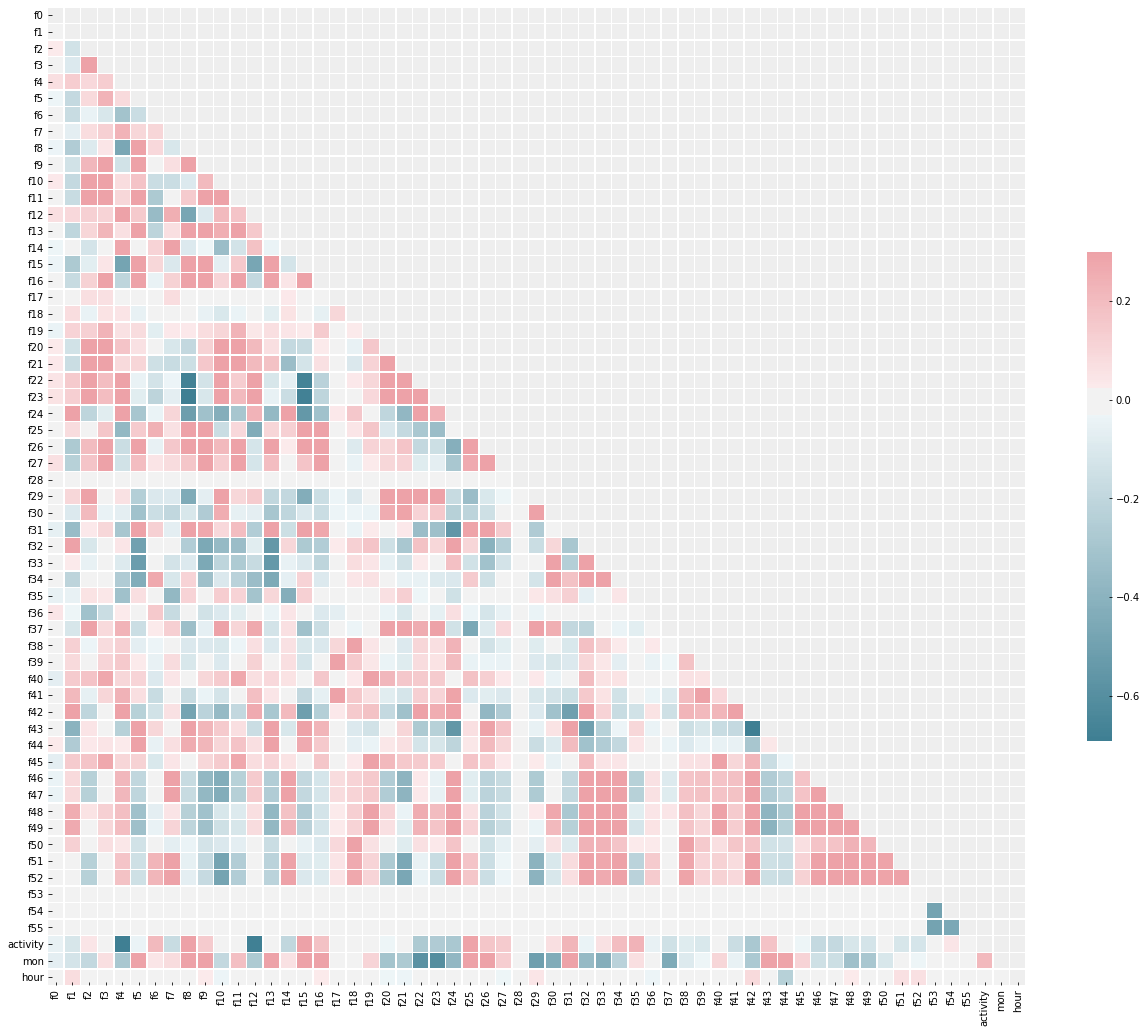

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt


corr = train_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [132]:
atac_train_data.head(1)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f51,f52,f53,f54,f55,atactic_1,atactic_2,atactic_3,hour,mon
date,,,,,,,,,,,,,,,,,,,,,
2018-02-14 08:00:00,50.623959,295.093024,1.630123,0.000043,0.022583,0.001564,1.716432e+06,694263.536388,1.276742,0.411108,...,332.76154,332.71643,483.874202,9210.35099,541.657805,7.7,7.9,7.5,8,2


Убираем проблемные колонки:

In [17]:
data.drop("f28", axis=1, inplace=True)

Text(0.5, 1, 'Activity')

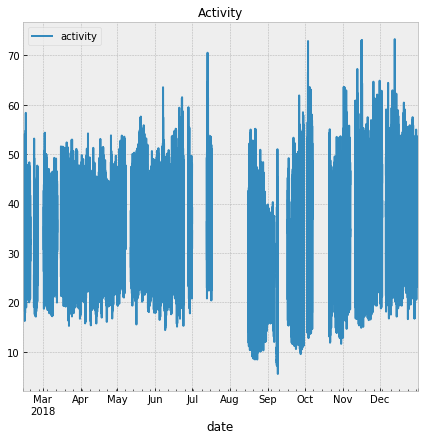

In [18]:
train_targets["activity"].plot()
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

Text(0.5, 1, 'Atactic fraction')

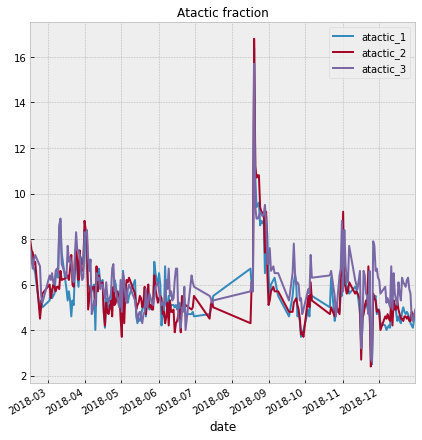

In [19]:
ACOLS = ["atactic_1", "atactic_2", "atactic_3"]

train_targets.loc[train_targets[ACOLS].notnull().all(axis=1), ACOLS].plot()
plt.legend(loc=0)
plt.tight_layout()
plt.title("Atactic fraction", fontsize=12)

# Признаки

In [20]:
PERIODS = ["1H", "3H", "6H"]
AGGREGATES = ["mean", "median", "std", "max", "min"]

In [21]:
all_features = []

for period in tqdm.tqdm_notebook(PERIODS):
    for agg in AGGREGATES:
        rolling_features = data.rolling(period).aggregate(agg)
        rolling_features.rename(lambda x: "_".join([x, period, agg]), axis=1, inplace=True)
        all_features.append(rolling_features)
all_features = pd.concat(all_features, axis=1)

In [22]:
full_data = data.join(all_features)

In [23]:
activity_data = train_targets[["activity"]].join(full_data.shift(6, freq="H"))
activity_data = activity_data[activity_data.notnull().all(axis=1)]

In [24]:
activity_data.head()

,activity,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f46_6H_min,f47_6H_min,f48_6H_min,f49_6H_min,f50_6H_min,f51_6H_min,f52_6H_min,f53_6H_min,f54_6H_min,f55_6H_min
date,,,,,,,,,,,,,,,,,,,,,
2018-02-13 14:31:00,26.492102,49.007980,294.932866,1.675090,0.000051,0.024659,0.001633,1.724523e+06,729611.819621,1.179814,...,335.66540,335.73734,336.9162,336.97977,342.95605,332.80826,332.78198,5247.641087,4829.339027,520.791888
2018-02-13 14:32:00,34.102710,48.994400,294.932703,1.675766,0.000051,0.024727,0.001639,1.724582e+06,730361.831348,1.179867,...,335.63095,335.70050,336.9162,336.97977,342.95605,332.80826,332.78198,5000.878811,4829.339027,520.242810
2018-02-13 14:33:00,41.518222,48.970760,294.936968,1.675868,0.000051,0.024723,0.001641,1.724677e+06,730486.077321,1.186719,...,335.57654,335.65533,336.9162,336.97977,342.95605,332.80826,332.78198,4751.941204,4829.339027,520.242810
2018-02-13 14:34:00,38.896862,48.952991,294.935404,1.675002,0.000051,0.024708,0.001646,1.724621e+06,730061.574144,1.186838,...,335.53976,335.63748,336.9162,336.97977,342.95605,332.80826,332.78198,4513.198853,4829.339027,520.242810
2018-02-13 14:35:00,42.422569,48.914230,294.937474,1.675524,0.000051,0.024708,0.001647,1.724709e+06,729853.531113,1.186829,...,335.53976,335.62650,336.9162,336.96692,342.95605,332.80826,332.78198,4266.654968,4829.339027,519.448876


In [25]:
tr_data = activity_data[:"2018-10-13"]
cv_data = activity_data["2018-10-14":]

## Тривиальные бенчмарки

In [26]:
print(f"MAPE (last known value, cross-validation set): {100 * mape(cv_data['activity'], tr_data['activity'].iloc[-1]):.2f}%")
print(f"MAPE (median, cross-validation set): {100 * mape(cv_data['activity'], tr_data['activity'].median()):.2f}%")

MAPE (last known value, cross-validation set): 10.99%
MAPE (median, cross-validation set): 13.54%


In [27]:
naive_baseline = activity_test_target.copy()
naive_baseline["rubber"] = tr_data['activity'].iloc[-1]
naive_baseline.to_csv(DATA_DIR.joinpath("activity_naive_baseline.csv"))

## Модель

In [28]:
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)

In [ ]:
tf.keras.backend.clear_session()

data_in = keras.Input(shape=(tr_data.shape[1]-1,), name="img_in")

dense_1 = layers.Dense(32, activation="relu")(data_in)
data_out = layers.Dense(1, activation="linear")(dense_1)
model = keras.Model(data_in, data_out)
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
EPOCHS = 500
BS = 1024

In [ ]:
center, scale = tr_data.iloc[:, 1:].mean().values, tr_data.iloc[:, 1:].std().values
trn = (tr_data.iloc[:, 1:].values - center)/scale
cvn = (cv_data.iloc[:, 1:].values - center)/scale

In [ ]:
model.fit(trn, (tr_data[["activity"]].values - tr_data["activity"].mean())/tr_data["activity"].std(),
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          validation_data=(cvn, (cv_data[["activity"]].values - tr_data["activity"].mean())/tr_data["activity"].std()),
          callbacks=[keras.callbacks.EarlyStopping(patience=5)])

In [ ]:
tr_preds = model.predict(trn) * tr_data["activity"].std() + tr_data["activity"].mean()
cv_preds = model.predict(cvn) * tr_data["activity"].std() + tr_data["activity"].mean()

tr_preds = pd.Series(tr_preds.flatten(), index=tr_data.index, name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv_data.index, name="activity_pred")

In [ ]:
tr_data["activity"].plot(c="steelblue")
cv_data["activity"].plot(c="steelblue", label="")
tr_preds.plot(c="forestgreen")
cv_preds.plot(c="firebrick")
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

In [ ]:
plt.scatter(tr_data["activity"], tr_preds, s=4, alpha=0.4, edgecolor="k", c="steelblue", label="training")
plt.scatter(cv_data["activity"], cv_preds, s=4, alpha=0.4, edgecolor="k", c="firebrick", label="cross-validation")

plt.xlim(5, 80)
plt.ylim(5, 80)
plt.legend(loc=0)
plt.plot([5, 80], [5, 80], "--", c="k", linewidth=1)
plt.xlabel("activity")
plt.ylabel("predicted activity")

In [ ]:
print(f"MAPE (training set): {100 * mape(tr_data['activity'].values, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data['activity'].values, cv_preds.values):.2f}%")

Наша модель недостаточно хорошо справляется со слишком большими и слишком маленькими значениями целевой переменной. Подумайте, как это исправить.

In [ ]:
test_activity_data = activity_test_target.join(full_data.shift(6, freq="H")).ffill()
ts_preds = model.predict((test_activity_data.values - center)/scale) * tr_data["activity"].std() + tr_data["activity"].mean()

ts_preds = pd.DataFrame(ts_preds, columns=["activity"], index=activity_test_target.index)
ts_preds.loc[activity_test_target.index].to_csv(DATA_DIR.joinpath("activity_nn_baseline.csv"))

# Атактика

В случае атактики у нас есть намного меньше данных. Будем предполагать, что сеть для прогноза активности катализатора строит представление, которые релевантные и для прогноза атактики.

In [ ]:
encoder_model = keras.Model(inputs=model.input,
                            outputs=model.get_layer("dense").output)

In [ ]:
tr_enc = encoder_model.predict(trn)
cv_enc = encoder_model.predict(cvn)

In [ ]:
tr_enc.shape

In [ ]:
tr_df = pd.DataFrame(tr_enc, columns=[f"enc{i}" for i in range(tr_enc.shape[1])], index=tr_data.index)
cv_df = pd.DataFrame(cv_enc, columns=[f"enc{i}" for i in range(cv_enc.shape[1])], index=cv_data.index)

Признаки уже сдвинуты на 6 часов, поэтому их не нужно сдвигать снова:

In [ ]:
atactic_data = train_targets[ACOLS].join(pd.concat([tr_df, cv_df]))

In [ ]:
atactic_data = atactic_data[atactic_data.notnull().all(axis=1)]

In [ ]:
atactic_data

In [ ]:
at_tr_data = atactic_data[:"2018-11-15"]
at_cv_data = atactic_data["2018-11-16":]

## Тривиальные бенчмарки

In [ ]:
mapes = []

for cl in ACOLS:
    local_mape = mape(at_cv_data[cl], at_tr_data[cl].iloc[-1])
    mapes.append(local_mape)
    
print(f"MAPE (last known value, cross-validation set): {100 * np.mean(mapes):.2f}%")

mapes = []

for cl in ACOLS:
    local_mape = mape(at_cv_data[cl], at_tr_data[cl].median())
    mapes.append(local_mape)

print(f"MAPE (median, cross-validation set): {100 * np.mean(mapes):.2f}%")

In [ ]:
naive_baseline = atactic_test_target.copy()

for cl in ACOLS:
    naive_baseline[cl] = at_tr_data[cl].iloc[-1]
naive_baseline.to_csv(DATA_DIR.joinpath("atactic_naive_baseline.csv"))

## Модели

In [ ]:
from sklearn.linear_model import LinearRegression, ARDRegression
from sklearn.ensemble import RandomForestRegressor

In [ ]:
tsn = (test_activity_data.values - center)/scale
ts_enc = encoder_model.predict(tsn)
ts_df = pd.DataFrame(ts_enc, columns=[f"enc{i}" for i in range(ts_enc.shape[1])], index=test_activity_data.index)

ts_atactic_data = atactic_test_target.join(ts_df)

In [ ]:
tr_mapes = []
cv_mapes = []
ts_preds = atactic_test_target.copy()

for cl in ACOLS:
    model =  ARDRegression()

    model.fit(at_tr_data.iloc[:, 3:], at_tr_data[cl])

    tr_preds = model.predict(at_tr_data.iloc[:, 3:])
    cv_preds = model.predict(at_cv_data.iloc[:, 3:])

    print(f"Target {cl}:")
    print(f"\tMAPE {cl} (training set): {100 * mape(at_tr_data[cl], tr_preds):.2f}%")
    print(f"\tMAPE {cl} (cross-validation set): {100 * mape(at_cv_data[cl], cv_preds):.2f}%")

    tr_mapes.append(mape(at_tr_data[cl], tr_preds))
    cv_mapes.append(mape(at_cv_data[cl], cv_preds))

    tr_preds = pd.Series(tr_preds, index=at_tr_data.index, name=f"{cl}_pred")
    cv_preds = pd.Series(cv_preds, index=at_cv_data.index, name=f"{cl}_pred")

    at_tr_data[cl].plot(c="steelblue")
    at_cv_data[cl].plot(c="steelblue", label="")
    tr_preds.plot(c="forestgreen")
    cv_preds.plot(c="firebrick")
    plt.legend(loc=0)
    plt.tight_layout()
    plt.title(cl, fontsize=12)
    plt.show()

    ts_preds[cl] = model.predict(ts_atactic_data)

print(f"MAPE (training set): {100 * np.mean(tr_mapes):.2f}%")
print(f"MAPE (cross-validation set): {100 * np.mean(cv_mapes):.2f}%")

In [ ]:
ts_preds.to_csv(DATA_DIR.joinpath("atactic_nn_baseline.csv"))